In [1]:
# for quantify the substrate

In [10]:
%cd ~/REVIVAL2
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

/disk2/fli/REVIVAL2


In [11]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs

from REVIVAL.global_param import LIB_INFO_DICT

/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [12]:
from rdkit import DataStructs

def compute_tanimoto_similarity(fp1, fp2):
    """Computes Tanimoto similarity between two fingerprints."""
    return DataStructs.FingerprintSimilarity(fp1, fp2)


In [32]:
common_cols = [
    "lib",
    "hd",
    "ev_score",
    "esm_score",
    "esmif_score_apo-score",
    "coves_score_apo_clean-output-100_processed",
    "Triad_score_score-frompdb-cleanup",
    "ligandmpnn_score",
    "flowsite_score",
    "dH", # "complexscore",
    "vina_apo-score-substrate_cofactor-docked",
    "var_vol",
]
common_heme_col = common_cols + [
    "chain_iptm_BA_avg_score_seperate_chai",
    "chain_pae_min_CA_avg_score_seperate_af3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    # "num_interactions_avg_af3-score_seperate"
]


common_col_dict = {
    "lib": "Library",
    "hd": "Hamming distance",
    "ev_score": "EVmutation",
    "esm_score": "ESM2",
    "esmif_score_apo-score": "ESM-IF",
    "coves_score_apo_clean-output-100_processed": "CoVES",
    "Triad_score_score-frompdb-cleanup": r"ΔΔ$G_f$",
    "ligandmpnn_score": "LigandMPNN",
    "flowsite_score": "FlowSite",
    "dH": "GALigandDock",
    # "complexscore": "GALigandock",
    "vina_apo-score-substrate_cofactor-docked": "Vina",
    "var_vol": "Active-site volume",
}
common_heme_col_dict = {
    **common_col_dict,
    "chain_iptm_BA_avg_score_seperate_chai": "Chai-1",
    "chain_pae_min_CA_avg_score_seperate_af3": "AF3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_seperate": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_seperate": "PLIP",
}

In [33]:
trpb_cols = common_cols + [
    "chain_iptm_AB_avg_score_joint_chai",
    "chain_pae_min_BA_avg_score_joint_af3",
    "2:GLU-NH_2_avg_af3-struct_joint",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    # "num_interactions_avg_af3-score_joint"
]

trpb_col_dict = {
    **common_col_dict,
    "chain_iptm_AB_avg_score_joint_chai": "Chai-1",
    "chain_pae_min_BA_avg_score_joint_af3": "AF3",
    "2:GLU-NH_2_avg_af3-struct_joint": "Bond distance",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_joint": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_joint": "PLIP",
}

parlq_cols = common_heme_col + ["0:C-C_1_avg_af3-struct_seperate"]

parlq_col_dict = {
    **common_heme_col_dict,
    "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
}

cb_col = common_heme_col + ["0:C-B_avg_af3-struct_seperate"]

cb_col_dict = {**common_heme_col_dict, "0:C-B_avg_af3-struct_seperate": "Bond distance"}

csi_col = common_heme_col + ["0:C-Si_avg_af3-struct_seperate"]
csi_col_dict = {
    **common_heme_col_dict,
    "0:C-Si_avg_af3-struct_seperate": "Bond distance",
}

final_col_order = [
    "Library",
    "Hamming distance",
    "EVmutation",
    "ESM2",
    "ESM-IF",
    "CoVES",
    r"ΔΔ$G_f$",  # "ΔΔG",
    "Vina",
    "GALigandDock",
    "AF3",
    "Chai-1",
    "LigandMPNN",
    "FlowSite",
    "Bond distance",
    "Hydrogen bonds",
    "Hydrophobicity",
    "Active-site volume",
]

In [34]:
lib_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ-a",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64


In [35]:
df_rho = pd.read_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_rho.csv")
df_rho

,lib,selectivity,n_mut,hd,ev_score,esm_score,flowsite_score,flowsite_std,ligandmpnn_score,var_vol,...,0:C-Si_agg_af3-struct_joint,0:C-Si_avg_af3-struct_joint,0:C-Si_std_af3-struct_joint,0:C-Si_agg_af3-struct_seperate,0:C-Si_avg_af3-struct_seperate,0:C-Si_std_af3-struct_seperate,0:C-Si_avg_chai-struct_joint,0:C-Si_std_chai-struct_joint,0:C-Si_avg_chai-struct_seperate,0:C-Si_std_chai-struct_seperate
0,ParLQ-a,0.961007,0.231575,-0.231575,0.064764,-0.016563,0.149739,0.767178,0.102997,0.000721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ParLQ-b,0.716367,0.214107,-0.214107,0.069212,-0.350559,-0.088342,0.002325,-0.364423,0.189141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ParLQ-c,0.922010,0.160432,-0.160432,0.109442,-0.260408,-0.125243,0.351489,-0.272798,0.119710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ParLQ-d,0.923523,0.131004,-0.131004,0.071439,-0.212725,0.159946,0.293343,0.013028,0.216661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ParLQ-e,0.885885,0.094295,-0.094295,0.003063,-0.126422,0.206172,0.045374,0.080714,0.115888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ParLQ-f,0.801194,0.099254,-0.099254,0.187746,-0.133461,0.054642,0.344720,-0.119939,0.153514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ParLQ-g,0.663896,0.064206,-0.064206,0.127933,-0.095302,0.129352,0.138254,0.049180,0.242398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ParLQ-h,0.914111,0.231071,-0.231071,0.052008,-0.302914,-0.164055,0.057270,-0.273802,0.245456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParLQ-i,0.720592,0.267521,-0.267521,-0.070933,-0.326358,-0.052970,0.223252,-0.226835,0.258078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PfTrpB-4bromo,NaN,-0.371285,0.371285,0.474594,0.478416,0.415240,0.212191,0.522690,0.196373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_rho.columns

Index(['lib', 'selectivity', 'n_mut', 'hd', 'ev_score', 'esm_score',
       'flowsite_score', 'flowsite_std', 'ligandmpnn_score', 'var_vol',
       ...
       '0:C-Si_agg_af3-struct_joint', '0:C-Si_avg_af3-struct_joint',
       '0:C-Si_std_af3-struct_joint', '0:C-Si_agg_af3-struct_seperate',
       '0:C-Si_avg_af3-struct_seperate', '0:C-Si_std_af3-struct_seperate',
       '0:C-Si_avg_chai-struct_joint', '0:C-Si_std_chai-struct_joint',
       '0:C-Si_avg_chai-struct_seperate', '0:C-Si_std_chai-struct_seperate'],
      dtype='object', length=2714)

In [18]:
df_rho['lib'] = df_rho['lib'].apply(lambda x: 'ParLQ-a' if x == 'ParLQ' else x)

In [19]:
trpb_df = df_rho[trpb_cols][df_rho["lib"].isin(lib_order[:11])].reset_index(drop=True).copy()
trpb_df["substrate"] = trpb_df["lib"].apply(lambda x: x.split("-")[1])
trpb_df

,lib,hd,ev_score,esm_score,esmif_score_apo-score,coves_score_apo_clean-output-100_processed,Triad_score_score-frompdb-cleanup,ligandmpnn_score,flowsite_score,dH,vina_apo-score-substrate_cofactor-docked,var_vol,chain_iptm_AB_avg_score_joint_chai,chain_pae_min_BA_avg_score_joint_af3,2:GLU-NH_2_avg_af3-struct_joint,pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint,num_hydrogen_bond_avg_af3-score_joint,substrate
0,PfTrpB-4bromo,0.371285,0.474594,0.478416,0.514151,0.480767,0.539204,0.522690,0.415240,0.032999,-0.039140,0.196373,0.373712,0.198803,0.382734,0.441648,0.375109,4bromo
1,PfTrpB-4cyano,0.234953,0.329215,0.352757,0.365879,0.316345,0.368595,0.356667,0.414012,0.059165,0.018610,0.045817,0.248836,0.261387,0.301838,0.320135,0.319412,4cyano
2,PfTrpB-56chloro,0.318860,0.388337,0.461043,0.455091,0.389999,0.459782,0.445602,0.316607,0.128804,0.022592,0.015341,-0.019656,0.176694,0.084174,0.373726,0.203336,56chloro
3,PfTrpB-5bromo,0.331510,0.487423,0.523450,0.490748,0.391023,0.519293,0.462262,0.404282,0.098258,-0.050464,0.027865,0.049795,0.236553,0.135002,0.434517,0.233364,5bromo
4,PfTrpB-5chloro,0.387294,0.521059,0.582487,0.521673,0.447818,0.575569,0.517904,0.375597,0.224014,-0.019768,0.003838,0.030885,0.241473,0.058986,0.490510,0.248458,5chloro
5,PfTrpB-5cyano,0.301809,0.396476,0.425708,0.401769,0.422838,0.467357,0.440015,0.382270,-0.021830,0.035948,0.052117,0.390956,0.236277,0.114252,0.346304,0.187445,5cyano
6,PfTrpB-5iodo,0.268085,0.419296,0.479928,0.474848,0.341682,0.413140,0.428536,0.426583,0.134698,0.005102,-0.063340,0.003273,0.233702,0.111872,0.336977,0.150707,5iodo
7,PfTrpB-6chloro,0.417893,0.569694,0.612678,0.536471,0.455386,0.627105,0.576349,0.457337,0.164824,-0.062791,0.059215,0.139696,0.273612,0.234978,0.442552,0.339977,6chloro
8,PfTrpB-7bromo,0.324373,0.539337,0.610375,0.511127,0.406650,0.583807,0.488873,0.406268,0.187197,0.276000,0.082739,0.282132,0.246079,0.210749,0.481811,0.266541,7bromo
9,PfTrpB-7iodo,0.369552,0.493195,0.548700,0.542172,0.456607,0.640249,0.523829,0.433207,0.243790,0.029047,0.089567,0.437605,0.308005,0.181878,0.413506,0.392083,7iodo


In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator, GetAtomPairGenerator

# Example SMILES strings
smiles_list = [
    "C12=C(C=CN2)C=CC=C1",  # indole
] + [v["substrate-smiles"] for k, v in LIB_INFO_DICT.items() if "PfTrpB-" in k]

name_list = ["indole"] + [v["substrate"] for k, v in LIB_INFO_DICT.items() if "PfTrpB-" in k]

# Convert SMILES to RDKit molecule objects
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Initialize fingerprint generators
morgan_gen = GetMorganGenerator(radius=20)  # Morgan (circular) fingerprint generator
atom_pair_gen = GetAtomPairGenerator()     # Atom-Pair fingerprint generator

# Function to compute Morgan Fingerprint
def compute_morgan_fingerprint(mol):
    return morgan_gen.GetFingerprint(mol)

# Function to compute MACCS keys
def compute_maccs_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

# Function to compute Atom-Pair Fingerprints
def compute_atom_pair_fingerprint(mol):
    return atom_pair_gen.GetFingerprint(mol)

# Compute fingerprints for each molecule
morgan_fps = [compute_morgan_fingerprint(mol) for mol in mols]
maccs_fps = [compute_maccs_fingerprint(mol) for mol in mols]
atom_pair_fps = [compute_atom_pair_fingerprint(mol) for mol in mols]

# Calculate pairwise similarity
num_molecules = len(morgan_fps)
morgan_matrix = [[0] * num_molecules for _ in range(num_molecules)]
maccs_matrix = [[0] * num_molecules for _ in range(num_molecules)]
atom_pair_matrix = [[0] * num_molecules for _ in range(num_molecules)]

# Compute similarity (Tanimoto) between molecules using Morgan fingerprints
for i in range(len(mols)):
    for j in range(i, len(mols)):
        morgan_matrix[i][j] = DataStructs.FingerprintSimilarity(morgan_fps[i], morgan_fps[j])
        morgan_matrix[j][i] = DataStructs.FingerprintSimilarity(morgan_fps[i], morgan_fps[j])

        maccs_matrix[i][j] = DataStructs.FingerprintSimilarity(maccs_fps[i], maccs_fps[j])
        maccs_matrix[j][i] = DataStructs.FingerprintSimilarity(maccs_fps[i], maccs_fps[j])

        atom_pair_matrix[i][j] = DataStructs.FingerprintSimilarity(atom_pair_fps[i], atom_pair_fps[j])
        atom_pair_matrix[j][i] = DataStructs.FingerprintSimilarity(atom_pair_fps[i], atom_pair_fps[j])

        # print(f"Morgan similarity between {smiles_list[i]} and {smiles_list[j]}: {similarity:.2f}")

# Compute Maximum Common Substructure (MCS)
# mcs = FindMCS(mols)
# mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
# mcs_smiles = Chem.MolToSmiles(mcs_mol)

# print(f"Maximum Common Substructure (MCS): {mcs_smiles}")


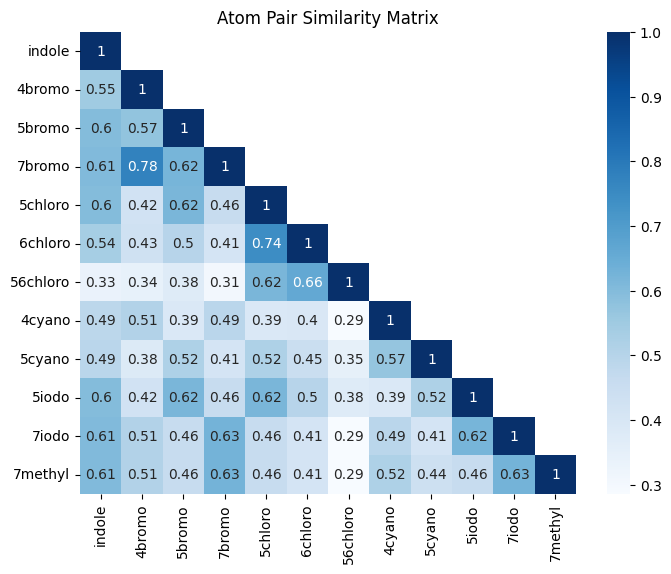

In [21]:
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(atom_pair_matrix, dtype=bool), k=1)
sns.heatmap(atom_pair_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("Atom Pair Similarity Matrix")
plt.show()

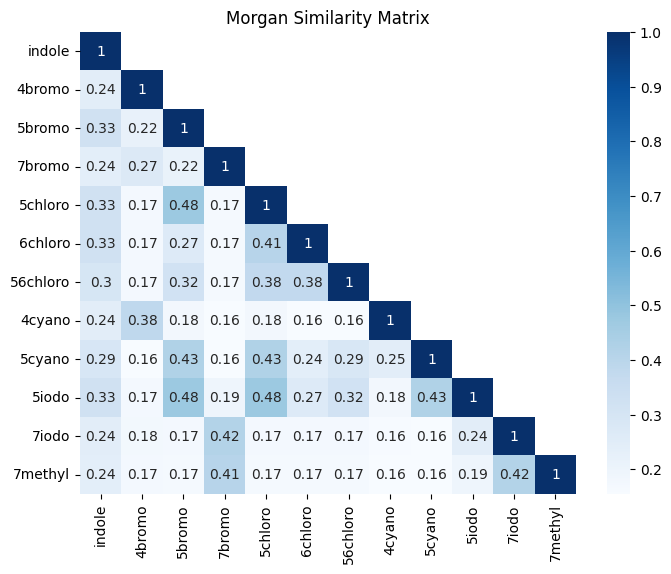

In [22]:
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(morgan_matrix, dtype=bool), k=1)
sns.heatmap(morgan_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("Morgan Similarity Matrix")
plt.show()

In [23]:
sm_df = pd.DataFrame({"substrate": name_list, "morgan": morgan_matrix[0], "MACCS": maccs_matrix[0], "Atom Pair": atom_pair_matrix[0]})
# similarity_matrix[0]
sm_df.sort_values(by="Atom Pair", ascending=False)

,substrate,morgan,MACCS,Atom Pair
0,indole,1.000000,1.000000,1.000000
3,7bromo,0.239130,0.777778,0.605263
10,7iodo,0.244444,0.777778,0.605263
11,7methyl,0.239130,0.933333,0.605263
2,5bromo,0.325581,0.777778,0.600000
4,5chloro,0.325581,0.777778,0.600000
9,5iodo,0.325581,0.777778,0.600000
1,4bromo,0.244444,0.777778,0.550000
5,6chloro,0.325581,0.777778,0.536585
8,5cyano,0.291667,0.875000,0.489796


In [24]:
mege_df = pd.merge(trpb_df, sm_df, on="substrate")
mege_df

,lib,hd,ev_score,esm_score,esmif_score_apo-score,coves_score_apo_clean-output-100_processed,Triad_score_score-frompdb-cleanup,ligandmpnn_score,flowsite_score,dH,...,var_vol,chain_iptm_AB_avg_score_joint_chai,chain_pae_min_BA_avg_score_joint_af3,2:GLU-NH_2_avg_af3-struct_joint,pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint,num_hydrogen_bond_avg_af3-score_joint,substrate,morgan,MACCS,Atom Pair
0,PfTrpB-4bromo,0.371285,0.474594,0.478416,0.514151,0.480767,0.539204,0.522690,0.415240,0.032999,...,0.196373,0.373712,0.198803,0.382734,0.441648,0.375109,4bromo,0.244444,0.777778,0.550000
1,PfTrpB-4cyano,0.234953,0.329215,0.352757,0.365879,0.316345,0.368595,0.356667,0.414012,0.059165,...,0.045817,0.248836,0.261387,0.301838,0.320135,0.319412,4cyano,0.244898,0.875000,0.489362
2,PfTrpB-56chloro,0.318860,0.388337,0.461043,0.455091,0.389999,0.459782,0.445602,0.316607,0.128804,...,0.015341,-0.019656,0.176694,0.084174,0.373726,0.203336,56chloro,0.295455,0.700000,0.333333
3,PfTrpB-5bromo,0.331510,0.487423,0.523450,0.490748,0.391023,0.519293,0.462262,0.404282,0.098258,...,0.027865,0.049795,0.236553,0.135002,0.434517,0.233364,5bromo,0.325581,0.777778,0.600000
4,PfTrpB-5chloro,0.387294,0.521059,0.582487,0.521673,0.447818,0.575569,0.517904,0.375597,0.224014,...,0.003838,0.030885,0.241473,0.058986,0.490510,0.248458,5chloro,0.325581,0.777778,0.600000
5,PfTrpB-5cyano,0.301809,0.396476,0.425708,0.401769,0.422838,0.467357,0.440015,0.382270,-0.021830,...,0.052117,0.390956,0.236277,0.114252,0.346304,0.187445,5cyano,0.291667,0.875000,0.489796
6,PfTrpB-5iodo,0.268085,0.419296,0.479928,0.474848,0.341682,0.413140,0.428536,0.426583,0.134698,...,-0.063340,0.003273,0.233702,0.111872,0.336977,0.150707,5iodo,0.325581,0.777778,0.600000
7,PfTrpB-6chloro,0.417893,0.569694,0.612678,0.536471,0.455386,0.627105,0.576349,0.457337,0.164824,...,0.059215,0.139696,0.273612,0.234978,0.442552,0.339977,6chloro,0.325581,0.777778,0.536585
8,PfTrpB-7bromo,0.324373,0.539337,0.610375,0.511127,0.406650,0.583807,0.488873,0.406268,0.187197,...,0.082739,0.282132,0.246079,0.210749,0.481811,0.266541,7bromo,0.239130,0.777778,0.605263
9,PfTrpB-7iodo,0.369552,0.493195,0.548700,0.542172,0.456607,0.640249,0.523829,0.433207,0.243790,...,0.089567,0.437605,0.308005,0.181878,0.413506,0.392083,7iodo,0.244444,0.777778,0.605263


In [26]:
# get separeman correlation between each numerical column in trpb_df and the column in sm_df
num_cols = trpb_df.columns[1:-1]
sm_cols = ["morgan", "MACCS", "Atom Pair"]
num_cols, sm_cols

(Index(['hd', 'ev_score', 'esm_score', 'esmif_score_apo-score',
        'coves_score_apo_clean-output-100_processed',
        'Triad_score_score-frompdb-cleanup', 'ligandmpnn_score',
        'flowsite_score', 'dH', 'vina_apo-score-substrate_cofactor-docked',
        'var_vol', 'chain_iptm_AB_avg_score_joint_chai',
        'chain_pae_min_BA_avg_score_joint_af3',
        '2:GLU-NH_2_avg_af3-struct_joint',
        'pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint',
        'num_hydrogen_bond_avg_af3-score_joint'],
       dtype='object'),
 ['morgan', 'MACCS', 'Atom Pair'])

In [29]:
sm_corr_df = []

for sm_col in sm_cols:
    for num_col in num_cols:
        rho, pval = spearmanr(mege_df[num_col], mege_df[sm_col])
        sm_corr_df.append({
            "num_col": num_col,
            "sm_col": sm_col,
            "rho": rho,
            "pval": pval,
        })

sm_corr_df = pd.DataFrame(sm_corr_df)
sm_corr_df

,num_col,sm_col,rho,pval
0,hd,morgan,-0.037398,0.913072
1,ev_score,morgan,-0.046747,0.891439
2,esm_score,morgan,0.018699,0.956483
3,esmif_score_apo-score,morgan,0.018699,0.956483
4,coves_score_apo_clean-output-100_processed,morgan,-0.056097,0.869873
5,Triad_score_score-frompdb-cleanup,morgan,-0.308533,0.355944
6,ligandmpnn_score,morgan,-0.112194,0.742590
7,flowsite_score,morgan,0.028048,0.934757
8,dH,morgan,0.084145,0.805702
9,vina_apo-score-substrate_cofactor-docked,morgan,-0.738608,0.009425


In [27]:
rho_dict = {}
p_dict = {}

for num_col in num_cols:
    rho, pval = spearmanr(mege_df[num_col], mege_df["Atom Pair"])
    rho_dict[num_col] = rho
    p_dict[num_col] = pval

In [28]:
rho_dict

{'hd': 0.3889555879527339,
 'ev_score': 0.6389984659223487,
 'esm_score': 0.6389984659223487,
 'esmif_score_apo-score': 0.5371291452680612,
 'coves_score_apo_clean-output-100_processed': 0.15743440464753516,
 'Triad_score_score-frompdb-cleanup': 0.6389984659223487,
 'ligandmpnn_score': 0.3982164352849419,
 'flowsite_score': 0.15743440464753516,
 'dH': 0.5371291452680612,
 'vina_apo-score-substrate_cofactor-docked': 0.3333905039594862,
 'var_vol': 0.037043389328831805,
 'chain_iptm_AB_avg_score_joint_chai': 0.3241296566272783,
 'chain_pae_min_BA_avg_score_joint_af3': 0.3982164352849419,
 '2:GLU-NH_2_avg_af3-struct_joint': 0.018521694664415903,
 'pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint': 0.5463899926002691,
 'num_hydrogen_bond_avg_af3-score_joint': 0.3611730459561101}

In [29]:
atom_pair_vals = dict(sm_df[["substrate", "Atom Pair"]].values)
atom_pair_vals.pop("indole")
atom_pair_vals = {k: v for k, v in sorted(atom_pair_vals.items(), key=lambda item: item[1], reverse=True)}

morgan_vals = dict(sm_df[["substrate", "morgan"]].values)
morgan_vals.pop("indole")
morgan_vals = {k: v for k, v in sorted(morgan_vals.items(), key=lambda item: item[1], reverse=True)}

In [30]:
atom_pair_vals

{'7bromo': 0.6052631578947368,
 '7iodo': 0.6052631578947368,
 '7methyl': 0.6052631578947368,
 '5bromo': 0.6,
 '5chloro': 0.6,
 '5iodo': 0.6,
 '4bromo': 0.55,
 '6chloro': 0.5365853658536586,
 '5cyano': 0.4897959183673469,
 '4cyano': 0.48936170212765956,
 '56chloro': 0.3333333333333333}

In [36]:
# Convert the 'substrate' column to a Categorical type with the custom order
# trpb_df['substrate'] = pd.Categorical(trpb_df['substrate'], categories=atom_pair_vals.keys(), ordered=True)

# # Sort the DataFrame based on the 'substrate' column
# trpb_df = trpb_df.sort_values('substrate')



#  Melt the dataframe to long format for seaborn boxplot and stripplot
trpbdf_melted = pd.melt(
    trpb_df.rename(columns=trpb_col_dict)[final_col_order + ["substrate"]].drop(columns=["Library"]),
    id_vars="substrate",
    var_name="ZS predictor",
    value_name="Spearman's ρ with activity",
)
# trpbdf_melted["ZS predictor"] = pd.Categorical(trpbdf_melted['ZS predictor'], categories=col_order, ordered=True)
# trpbdf_melted = trpbdf_melted.sort_values(['substrate','ZS predictor'])
trpbdf_melted

,substrate,ZS predictor,Spearman's ρ with activity
0,4bromo,Hamming distance,0.371285
1,4cyano,Hamming distance,0.234953
2,56chloro,Hamming distance,0.318860
3,5bromo,Hamming distance,0.331510
4,5chloro,Hamming distance,0.387294
...,...,...,...
171,5iodo,Active-site volume,-0.063340
172,6chloro,Active-site volume,0.059215
173,7bromo,Active-site volume,0.082739
174,7iodo,Active-site volume,0.089567


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
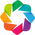

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import numpy as np
from REVIVAL.vis_param import FZL_PALETTES

%matplotlib inline

/tmp/ipykernel_442262/3602464399.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Blues_r")
/tmp/ipykernel_442262/3602464399.py:81: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


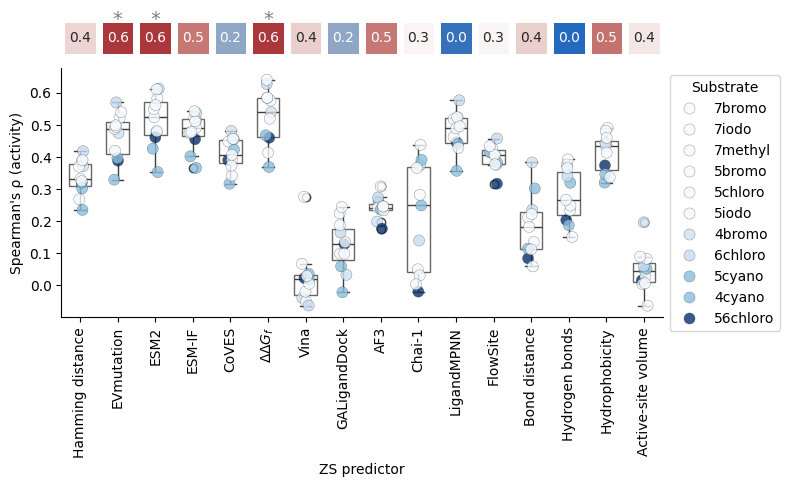

In [38]:

# Heatmap values
heatmap_values = atom_pair_vals
trpbdf_melted["atom_pair"] = trpbdf_melted["substrate"].map(heatmap_values)

# Normalize heatmap values for colormap
norm = Normalize(vmin=min(heatmap_values.values()), vmax=max(heatmap_values.values()))
cmap = get_cmap("Blues_r")

# Map substrates to colors
substrate_colors = {substrate: cmap(norm(value)) for substrate, value in heatmap_values.items()}

# Define figure with two subplots using GridSpec
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])  # Small heatmap row, larger boxplot

# --- Heatmap Row (Top) ---
ax_heatmap = plt.subplot(gs[0])
rho_data = pd.DataFrame([rho_dict])  # Create DataFrame for heatmap

sns.heatmap(
    rho_data,
    cmap="vlag",
    annot=True,
    cbar=False,
    fmt=".1f",
    xticklabels=rho_dict.keys(),
    yticklabels=[],
    linewidths=5,
    linecolor="white",
    ax=ax_heatmap,
    square=True,
)

# Add asterisks for p-values < 0.05
for i, (key, p_val) in enumerate(p_dict.items()):
    if p_val < 0.05:
        ax_heatmap.text(i + 0.5, 0, "*", fontsize=14, ha="center", va="center", color="gray")


# Format heatmap
# ax_heatmap.xaxis.tick_top()  # Move x-ticks to top
# remove x-ticks
ax_heatmap.set_xticks([])
ax_heatmap.tick_params(axis="x", rotation=90)  # Rotate labels
ax_heatmap.set_xticklabels([])
ax_heatmap.set_yticks([])  # Hide y-axis ticks
ax_heatmap.spines["top"].set_visible(False)
ax_heatmap.spines["right"].set_visible(False)
ax_heatmap.spines["left"].set_visible(False)
ax_heatmap.spines["bottom"].set_visible(False)

# --- Circle-based Heatmap (Top) ---
# ax_heatmap = plt.subplot(gs[0])
# ax_heatmap.set_xlim(-0.5, len(rho_dict) - 0.5)  # Match x-axis range to number of substrates
# ax_heatmap.set_ylim(0, 1)  # Single row for circles
# ax_heatmap.set_xticks(range(len(rho_dict)))  # Align x-ticks with substrate positions
# ax_heatmap.set_xticklabels([])
# ax_heatmap.set_yticks([])  # Remove y-axis labels

# # Scatter plot to simulate heatmap circles
# for i, (substrate, value) in enumerate(rho_dict.items()):
#     ax_heatmap.scatter(i, 0.5, s=250, color=get_cmap("vlag")(norm(value)), edgecolor="gray", linewidth=0.5)

# # Remove borders
# ax_heatmap.spines["top"].set_visible(False)
# ax_heatmap.spines["right"].set_visible(False)
# ax_heatmap.spines["left"].set_visible(False)
# ax_heatmap.spines["bottom"].set_visible(False)

# --- Boxplot and Stripplot (Bottom) ---
ax = plt.subplot(gs[1])
sns.boxplot(
    x="ZS predictor",
    y="Spearman's ρ with activity",
    data=trpbdf_melted,
    boxprops={"facecolor": "None", "edgecolor": FZL_PALETTES["gray"]},
    width=0.6,
    ax=ax,
)

sns.stripplot(
    x="ZS predictor",
    y="Spearman's ρ with activity",
    hue="substrate",
    data=trpbdf_melted,
    palette=substrate_colors,  
    jitter=True,
    size=8,
    marker="o",
    edgecolor="gray",
    linewidth=0.2,
    alpha=0.8,
    ax=ax,
    hue_order=heatmap_values.keys(),
)

# Format boxplot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", rotation=90)  # Rotate x labels

# Adjust legend
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Substrate")

# Rename y-axis
ax.set_ylabel("Spearman's ρ (activity)")

# Save the figure
 #plt.savefig("figs/trpb.svg", format="svg", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


In [39]:
cb_df = df_rho[df_rho["lib"] == "Rma-CB"][cb_col].rename(columns=cb_col_dict).reset_index(drop=True).copy()
csi_df = df_rho[df_rho["lib"] == "Rma-CSi"][csi_col].rename(columns=csi_col_dict).reset_index(drop=True).copy()
parlq_df = df_rho[df_rho["lib"].isin(lib_order[-9:])][parlq_cols].rename(columns=parlq_col_dict).reset_index(drop=True).copy()
parlq_df.loc[parlq_df["Library"]=="ParLQ", "Library"] = "ParLQ-a"
new2nature_df = pd.concat([cb_df, csi_df, parlq_df], axis=0).reset_index(drop=True).sort_values(by="Library")
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,ΔΔ$G_f$,LigandMPNN,FlowSite,GALigandDock,Vina,Active-site volume,Chai-1,AF3,Hydrophobicity,Hydrogen bonds,Bond distance
2,ParLQ-a,-0.231575,0.064764,-0.016563,0.278441,0.035015,0.278514,0.102997,0.149739,0.503742,-0.003070,0.000721,-0.127618,0.356036,0.383057,-0.182839,0.139871
3,ParLQ-b,-0.214107,0.069212,-0.350559,-0.138534,-0.425412,-0.229385,-0.364423,-0.088342,0.136854,0.045758,0.189141,0.116930,0.193525,-0.098895,-0.045918,-0.051744
4,ParLQ-c,-0.160432,0.109442,-0.260408,-0.040022,-0.311929,-0.201736,-0.272798,-0.125243,0.213983,0.123865,0.119710,0.104380,0.256742,-0.073357,0.168407,-0.278818
5,ParLQ-d,-0.131004,0.071439,-0.212725,-0.055805,-0.100844,-0.205686,0.013028,0.159946,0.229113,0.044362,0.216661,0.047746,0.365860,-0.068977,0.156444,-0.164341
6,ParLQ-e,-0.094295,0.003063,-0.126422,0.088398,-0.013673,-0.012988,0.080714,0.206172,0.025984,0.006217,0.115888,0.001640,0.335681,-0.047357,0.046059,-0.083095
7,ParLQ-f,-0.099254,0.187746,-0.133461,0.069135,-0.139975,-0.088788,-0.119939,0.054642,0.014445,0.057543,0.153514,-0.033126,0.278623,-0.038439,0.095870,-0.010543
8,ParLQ-g,-0.064206,0.127933,-0.095302,0.066109,0.009333,0.019541,0.049180,0.129352,0.079153,-0.064561,0.242398,0.040373,0.289401,-0.025912,0.025332,-0.083485
9,ParLQ-h,-0.231071,0.052008,-0.302914,-0.084647,-0.228062,-0.067718,-0.273802,-0.164055,0.136327,0.122815,0.245456,0.116499,0.275381,-0.053305,-0.072234,-0.012024
10,ParLQ-i,-0.267521,-0.070933,-0.326358,-0.094187,-0.130690,-0.226039,-0.226835,-0.052970,0.030180,0.016541,0.258078,0.225131,0.283123,-0.107756,0.040276,-0.020529
0,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.290381,0.071539,-0.153503,0.173947,0.362757,0.099902,0.174850,0.037481


In [89]:
thermo_energy = {
    "ParLQ-a": -44.6074902,
    "ParLQ-b": -44.732016,
    "ParLQ-c": -44.5279905,
    "ParLQ-d": -46.3590099,
    "ParLQ-e": -45.8876628,
    "ParLQ-f": -45.5328027,
    "ParLQ-g": -46.0807389,
    "ParLQ-h": -75.270384,
    "ParLQ-i": -45.5365323,
    "Rma-CSi": -62.6219811,
    "Rma-CB": -54.8434152, 
}



# -54.8434152
# -62.6219811

# Rma-CB
# Rma-Csi

# ParLQ: -44.6074902
# Rma-CB: -54.8434152
# Rma-CSi: -62.6219811

# thermo_energy = {
#     "ParLQ-a": 11,
#     "ParLQ-b": 14.5,
#     "ParLQ-c": 12.5,
#     "ParLQ-d": 13.5,
#     "ParLQ-e": 16,
#     "ParLQ-f": 17,
#     "ParLQ-g": 18,
#     "ParLQ-h": 20,
#     "ParLQ-i": 21,
#     "Rma-CSi": 19,
#     "Rma-CB": 13,
# }
thermo_energy = {k: v for k, v in sorted(thermo_energy.items(), key=lambda item: item[1])}

In [90]:
# pd.DataFrame([thermo_energy]).T # add column name
new2nature_df["energy"] = new2nature_df["Library"].map(thermo_energy)
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,ΔΔ$G_f$,LigandMPNN,FlowSite,GALigandDock,Vina,Active-site volume,Chai-1,AF3,Hydrophobicity,Hydrogen bonds,Bond distance,energy
0,ParLQ-a,-0.231575,0.064764,-0.016563,0.278441,0.035015,0.278514,0.102997,0.149739,0.503742,-0.003070,0.000721,-0.127618,0.356036,0.383057,-0.182839,0.139871,-44.607490
1,ParLQ-b,-0.214107,0.069212,-0.350559,-0.138534,-0.425412,-0.229385,-0.364423,-0.088342,0.136854,0.045758,0.189141,0.116930,0.193525,-0.098895,-0.045918,-0.051744,-44.732016
2,ParLQ-c,-0.160432,0.109442,-0.260408,-0.040022,-0.311929,-0.201736,-0.272798,-0.125243,0.213983,0.123865,0.119710,0.104380,0.256742,-0.073357,0.168407,-0.278818,-44.527991
3,ParLQ-d,-0.131004,0.071439,-0.212725,-0.055805,-0.100844,-0.205686,0.013028,0.159946,0.229113,0.044362,0.216661,0.047746,0.365860,-0.068977,0.156444,-0.164341,-46.359010
4,ParLQ-e,-0.094295,0.003063,-0.126422,0.088398,-0.013673,-0.012988,0.080714,0.206172,0.025984,0.006217,0.115888,0.001640,0.335681,-0.047357,0.046059,-0.083095,-45.887663
5,ParLQ-f,-0.099254,0.187746,-0.133461,0.069135,-0.139975,-0.088788,-0.119939,0.054642,0.014445,0.057543,0.153514,-0.033126,0.278623,-0.038439,0.095870,-0.010543,-45.532803
6,ParLQ-g,-0.064206,0.127933,-0.095302,0.066109,0.009333,0.019541,0.049180,0.129352,0.079153,-0.064561,0.242398,0.040373,0.289401,-0.025912,0.025332,-0.083485,-46.080739
7,ParLQ-h,-0.231071,0.052008,-0.302914,-0.084647,-0.228062,-0.067718,-0.273802,-0.164055,0.136327,0.122815,0.245456,0.116499,0.275381,-0.053305,-0.072234,-0.012024,-75.270384
8,ParLQ-i,-0.267521,-0.070933,-0.326358,-0.094187,-0.130690,-0.226039,-0.226835,-0.052970,0.030180,0.016541,0.258078,0.225131,0.283123,-0.107756,0.040276,-0.020529,-45.536532
9,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.290381,0.071539,-0.153503,0.173947,0.362757,0.099902,0.174850,0.037481,-54.843415


In [91]:
# Convert the 'substrate' column to a Categorical type with the custom order
# trpb_df['substrate'] = pd.Categorical(trpb_df['substrate'], categories=atom_pair_vals.keys(), ordered=True)

# # Sort the DataFrame based on the 'substrate' column
# trpb_df = trpb_df.sort_values('substrate')



#  Melt the dataframe to long format for seaborn boxplot and stripplot
new2nature_melted = pd.melt(
    new2nature_df[final_col_order],
    id_vars="Library",
    var_name="ZS predictor",
    value_name="Spearman's ρ with activity",
)
# trpbdf_melted["ZS predictor"] = pd.Categorical(trpbdf_melted['ZS predictor'], categories=col_order, ordered=True)
# trpbdf_melted = trpbdf_melted.sort_values(['substrate','ZS predictor'])
new2nature_melted

,Library,ZS predictor,Spearman's ρ with activity
0,ParLQ-a,Hamming distance,-0.231575
1,ParLQ-b,Hamming distance,-0.214107
2,ParLQ-c,Hamming distance,-0.160432
3,ParLQ-d,Hamming distance,-0.131004
4,ParLQ-e,Hamming distance,-0.094295
...,...,...,...
171,ParLQ-g,Active-site volume,0.242398
172,ParLQ-h,Active-site volume,0.245456
173,ParLQ-i,Active-site volume,0.258078
174,Rma-CB,Active-site volume,-0.153503


In [92]:
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,ΔΔ$G_f$,LigandMPNN,FlowSite,GALigandDock,Vina,Active-site volume,Chai-1,AF3,Hydrophobicity,Hydrogen bonds,Bond distance,energy
0,ParLQ-a,-0.231575,0.064764,-0.016563,0.278441,0.035015,0.278514,0.102997,0.149739,0.503742,-0.003070,0.000721,-0.127618,0.356036,0.383057,-0.182839,0.139871,-44.607490
1,ParLQ-b,-0.214107,0.069212,-0.350559,-0.138534,-0.425412,-0.229385,-0.364423,-0.088342,0.136854,0.045758,0.189141,0.116930,0.193525,-0.098895,-0.045918,-0.051744,-44.732016
2,ParLQ-c,-0.160432,0.109442,-0.260408,-0.040022,-0.311929,-0.201736,-0.272798,-0.125243,0.213983,0.123865,0.119710,0.104380,0.256742,-0.073357,0.168407,-0.278818,-44.527991
3,ParLQ-d,-0.131004,0.071439,-0.212725,-0.055805,-0.100844,-0.205686,0.013028,0.159946,0.229113,0.044362,0.216661,0.047746,0.365860,-0.068977,0.156444,-0.164341,-46.359010
4,ParLQ-e,-0.094295,0.003063,-0.126422,0.088398,-0.013673,-0.012988,0.080714,0.206172,0.025984,0.006217,0.115888,0.001640,0.335681,-0.047357,0.046059,-0.083095,-45.887663
5,ParLQ-f,-0.099254,0.187746,-0.133461,0.069135,-0.139975,-0.088788,-0.119939,0.054642,0.014445,0.057543,0.153514,-0.033126,0.278623,-0.038439,0.095870,-0.010543,-45.532803
6,ParLQ-g,-0.064206,0.127933,-0.095302,0.066109,0.009333,0.019541,0.049180,0.129352,0.079153,-0.064561,0.242398,0.040373,0.289401,-0.025912,0.025332,-0.083485,-46.080739
7,ParLQ-h,-0.231071,0.052008,-0.302914,-0.084647,-0.228062,-0.067718,-0.273802,-0.164055,0.136327,0.122815,0.245456,0.116499,0.275381,-0.053305,-0.072234,-0.012024,-75.270384
8,ParLQ-i,-0.267521,-0.070933,-0.326358,-0.094187,-0.130690,-0.226039,-0.226835,-0.052970,0.030180,0.016541,0.258078,0.225131,0.283123,-0.107756,0.040276,-0.020529,-45.536532
9,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.290381,0.071539,-0.153503,0.173947,0.362757,0.099902,0.174850,0.037481,-54.843415


In [93]:
new2nature_df.columns[1:-1]

Index(['Hamming distance', 'EVmutation', 'ESM2', 'ESM-IF', 'CoVES', 'ΔΔ$G_f$',
       'LigandMPNN', 'FlowSite', 'GALigandDock', 'Vina', 'Active-site volume',
       'Chai-1', 'AF3', 'Hydrophobicity', 'Hydrogen bonds', 'Bond distance'],
      dtype='object')

In [94]:
rho_dict = {}
p_dict = {}
new2nature_df = new2nature_df.reset_index(drop=True)
for num_col in final_col_order[1:]:
    rho, pval = spearmanr(new2nature_df[num_col], -new2nature_df["energy"])
    rho_dict[num_col] = rho
    p_dict[num_col] = pval

In [95]:
rho_dict

{'Hamming distance': 0.44545454545454555,
 'EVmutation': 0.1272727272727273,
 'ESM2': 0.30000000000000004,
 'ESM-IF': -0.05454545454545456,
 'CoVES': 0.3454545454545455,
 'ΔΔ$G_f$': 0.28181818181818186,
 'Vina': 0.20000000000000004,
 'GALigandDock': -0.10000000000000002,
 'AF3': 0.4909090909090909,
 'Chai-1': 0.38181818181818183,
 'LigandMPNN': 0.3090909090909091,
 'FlowSite': 0.02727272727272728,
 'Bond distance': -0.03636363636363637,
 'Hydrogen bonds': 0.13636363636363638,
 'Hydrophobicity': 0.1272727272727273,
 'Active-site volume': 0.045454545454545456}

/tmp/ipykernel_442262/2580767937.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Greens")
/tmp/ipykernel_442262/2580767937.py:86: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


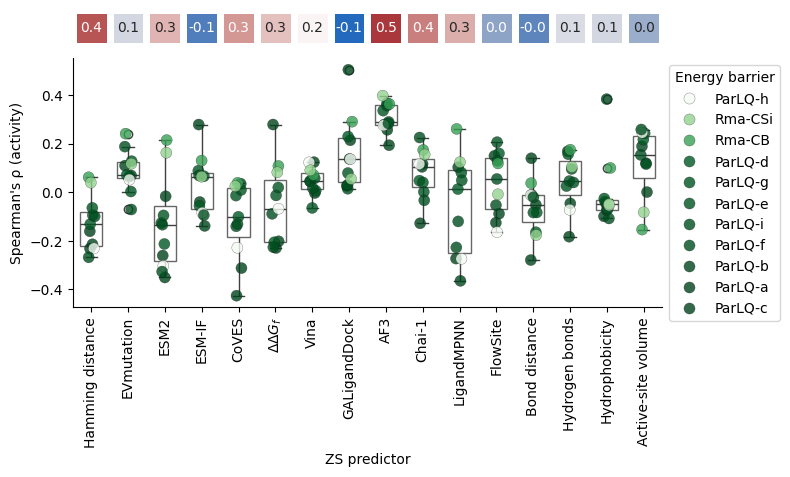

In [96]:
from matplotlib.colors import LinearSegmentedColormap

# Heatmap values
heatmap_values = thermo_energy
new2nature_melted["energy"] = new2nature_melted["Library"].map(heatmap_values)

# Normalize heatmap values for colormap
norm = Normalize(vmin=min(heatmap_values.values()), vmax=max(heatmap_values.values()))
cmap = get_cmap("Greens")
# Create a new colormap using only the lighter portion of "Greens"
# cmap = LinearSegmentedColormap.from_list("lighter_greens", orig_cmap(np.linspace(0, 0.6, 12)))


# Map substrates to colors
substrate_colors = {substrate: cmap(norm(value)) for substrate, value in heatmap_values.items()}

# Define figure with two subplots using GridSpec
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])  # Small heatmap row, larger boxplot

# --- Heatmap Row (Top) ---
ax_heatmap = plt.subplot(gs[0])
  # Create DataFrame for heatmap

sns.heatmap(
    pd.DataFrame([rho_dict]),
    cmap="vlag",
    annot=True,
    cbar=False,
    fmt=".1f",
    xticklabels=rho_dict.keys(),
    yticklabels=[],
    linewidths=5,
    linecolor="white",
    ax=ax_heatmap,
    square=True,
)

# Add asterisks for p-values < 0.05
for i, (key, p_val) in enumerate(p_dict.items()):
    if p_val < 0.05:
        ax_heatmap.text(i + 0.5, 0, "*", fontsize=14, ha="center", va="center", color="gray")


# Format heatmap
# ax_heatmap.xaxis.tick_top()  # Move x-ticks to top
# remove x-ticks
ax_heatmap.set_xticks([])
ax_heatmap.tick_params(axis="x", rotation=90)  # Rotate labels
ax_heatmap.set_xticklabels([])
ax_heatmap.set_yticks([])  # Hide y-axis ticks
ax_heatmap.spines["top"].set_visible(False)
ax_heatmap.spines["right"].set_visible(False)
ax_heatmap.spines["left"].set_visible(False)
ax_heatmap.spines["bottom"].set_visible(False)

# --- Circle-based Heatmap (Top) ---
# ax_heatmap = plt.subplot(gs[0])
# ax_heatmap.set_xlim(-0.5, len(rho_dict) - 0.5)  # Match x-axis range to number of substrates
# ax_heatmap.set_ylim(0, 1)  # Single row for circles
# ax_heatmap.set_xticks(range(len(rho_dict)))  # Align x-ticks with substrate positions
# ax_heatmap.set_xticklabels([])
# ax_heatmap.set_yticks([])  # Remove y-axis labels

# # Scatter plot to simulate heatmap circles
# for i, (substrate, value) in enumerate(rho_dict.items()):
#     ax_heatmap.scatter(i, 0.5, s=250, color=get_cmap("vlag")(norm(value)), edgecolor="gray", linewidth=0.5)

# # Remove borders
# ax_heatmap.spines["top"].set_visible(False)
# ax_heatmap.spines["right"].set_visible(False)
# ax_heatmap.spines["left"].set_visible(False)
# ax_heatmap.spines["bottom"].set_visible(False)

# --- Boxplot and Stripplot (Bottom) ---
ax = plt.subplot(gs[1])
sns.boxplot(
    x="ZS predictor",
    y="Spearman's ρ with activity",
    data=new2nature_melted,
    boxprops={"facecolor": "None", "edgecolor": FZL_PALETTES["gray"]},
    width=0.6,
    ax=ax,
)

sns.stripplot(
    x="ZS predictor",
    y="Spearman's ρ with activity",
    hue="Library",
    data=new2nature_melted,
    palette=substrate_colors,  
    jitter=True,
    size=8,
    marker="o",
    edgecolor="gray",
    linewidth=0.2,
    alpha=0.8,
    ax=ax,
    hue_order=heatmap_values.keys(),
)

# Format boxplot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", rotation=90)  # Rotate x labels

# Adjust legend
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Energy barrier")

# Rename y-axis
ax.set_ylabel("Spearman's ρ (activity)")

# Save the figure
# plt.savefig("figs/new2nature.svg", format="svg", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()
